# Social Volatility: Financial Volatility

In [1]:
# Importing packages.
from datetime import datetime, timedelta

# Resolving paths in a platform agnostic way.
from os import path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Manipulating the raw data to save it in a ``.csv`` files.
from pandas import DataFrame, DatetimeIndex
from pandas import concat as concat_df
from pandas import date_range

In [2]:
# Create and resolve paths to the data in an OS agnostic way.
def is_interactive():
    """Check if the script is being run interactively."""
    import __main__ as main

    return not hasattr(main, "__file__")


if is_interactive():
    SCRIPT_DIR = path.dirname(path.realpath("__file__"))
else:
    SCRIPT_DIR = path.dirname(path.realpath(__file__))

# "../data"
DATA_DIR = path.join(path.dirname(SCRIPT_DIR), "data")

In [3]:
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return t.replace(
        second=0, microsecond=0, minute=0, hour=t.hour
    ) + timedelta(hours=t.minute // 30)

In [4]:
# Read in the raw cryptocurrency data.
CRYPTOCURRENCIES = {
    "BTC": "bitcoin",
    "ETH": "ethereum",
    "DOGE": "doge",
    "SOL": "solana",
    "AVAX": "avalanche",
}


def load_dataset(
    cryptocurrency: str, start_date: datetime, end_date: datetime
):
    filename = path.join(
        DATA_DIR,
        "raw",
        "crypto",
        f"{cryptocurrency.lower()}_{start_date.strftime('%Y_%m_%d')}"
        f"-{end_date.strftime('%Y_%m_%d')}_minute.csv",
    )
    crypto_df = pd.read_csv(filename, index_col=0)
    crypto_df = crypto_df[["time", "open"]].rename({"open": "price"}, axis=1)
    crypto_df["time"] = crypto_df["time"].transform(datetime.fromtimestamp)
    crypto_df["cryptocurrency"] = cryptocurrency

    return crypto_df


start_date = datetime(2022, 3, 5)
end_date = datetime(2022, 3, 11)
btc_prices = load_dataset("BTC", start_date, end_date)
btc_prices.head()

,time,price,cryptocurrency
0,2022-03-04 12:50:00,40787.05,BTC
1,2022-03-04 12:51:00,40783.59,BTC
2,2022-03-04 12:52:00,40793.84,BTC
3,2022-03-04 12:53:00,40798.03,BTC
4,2022-03-04 12:54:00,40816.49,BTC


In [5]:
def calculate_returns(prices: DataFrame):
    prices["minutely_return"] = np.log(prices["price"].pct_change() + 1)
    return prices


btc_prices = calculate_returns(btc_prices)
btc_prices.head()

,time,price,cryptocurrency,minutely_return
0,2022-03-04 12:50:00,40787.05,BTC,NaN
1,2022-03-04 12:51:00,40783.59,BTC,-0.000085
2,2022-03-04 12:52:00,40793.84,BTC,0.000251
3,2022-03-04 12:53:00,40798.03,BTC,0.000103
4,2022-03-04 12:54:00,40816.49,BTC,0.000452


In [6]:
def calculate_financial_volatility(prices: DataFrame):
    """Calculate the minutely volatility"""
    prices["minutely_volatility"] = prices["minutely_return"].rolling(
        window=2
    ).std() * np.sqrt(2)
    return prices


btc_prices = calculate_financial_volatility(btc_prices)
btc_prices.head()

,time,price,cryptocurrency,minutely_return,minutely_volatility
0,2022-03-04 12:50:00,40787.05,BTC,NaN,NaN
1,2022-03-04 12:51:00,40783.59,BTC,-0.000085,NaN
2,2022-03-04 12:52:00,40793.84,BTC,0.000251,0.000336
3,2022-03-04 12:53:00,40798.03,BTC,0.000103,0.000149
4,2022-03-04 12:54:00,40816.49,BTC,0.000452,0.000350


In [7]:
def transform_data_through_pipeline(prices: DataFrame):
    """Transform the data through the pipeline"""
    return prices.pipe(calculate_returns).pipe(calculate_financial_volatility)


btc_prices = transform_data_through_pipeline(btc_prices)
btc_prices.head()

,time,price,cryptocurrency,minutely_return,minutely_volatility
0,2022-03-04 12:50:00,40787.05,BTC,NaN,NaN
1,2022-03-04 12:51:00,40783.59,BTC,-0.000085,NaN
2,2022-03-04 12:52:00,40793.84,BTC,0.000251,0.000336
3,2022-03-04 12:53:00,40798.03,BTC,0.000103,0.000149
4,2022-03-04 12:54:00,40816.49,BTC,0.000452,0.000350


In [8]:
def get_financial_volatilitys(
    cryptocurrency: str, start_date: datetime, end_date: datetime
):
    """Calculate the financial volatility for all cryptocurrencies"""
    crypto_df = load_dataset(cryptocurrency, start_date, end_date)
    crypto_df = transform_data_through_pipeline(crypto_df)
    return crypto_df

In [9]:
def append_financial_volatilities(start_date: datetime, end_date: datetime):
    """Append the financial volatility for all cryptocurrencies"""
    global btc_prices, eth_prices, doge_prices, sol_prices, avax_prices
    btc_prices = pd.concat(
        [btc_prices, get_financial_volatilitys("BTC", start_date, end_date)]
    )
    eth_prices = pd.concat(
        [eth_prices, get_financial_volatilitys("ETH", start_date, end_date)]
    )
    doge_prices = pd.concat(
        [doge_prices, get_financial_volatilitys("DOGE", start_date, end_date)]
    )
    sol_prices = pd.concat(
        [sol_prices, get_financial_volatilitys("SOL", start_date, end_date)]
    )
    avax_prices = pd.concat(
        [avax_prices, get_financial_volatilitys("AVAX", start_date, end_date)]
    )

In [10]:
btc_prices = DataFrame()
eth_prices = DataFrame()
doge_prices = DataFrame()
sol_prices = DataFrame()
avax_prices = DataFrame()

start_date = datetime(2022, 3, 5)
end_date = datetime(2022, 3, 11)

append_financial_volatilities(start_date, end_date)

start_date = datetime(2022, 3, 28)
end_date = datetime(2022, 4, 4)

append_financial_volatilities(start_date, end_date)

print(btc_prices.head())
print(btc_prices.tail())

                 time     price cryptocurrency  minutely_return  \
0 2022-03-04 12:50:00  40787.05            BTC              NaN   
1 2022-03-04 12:51:00  40783.59            BTC        -0.000085   
2 2022-03-04 12:52:00  40793.84            BTC         0.000251   
3 2022-03-04 12:53:00  40798.03            BTC         0.000103   
4 2022-03-04 12:54:00  40816.49            BTC         0.000452   

   minutely_volatility  
0                  NaN  
1                  NaN  
2             0.000336  
3             0.000149  
4             0.000350  
                     time     price cryptocurrency  minutely_return  \
10082 2022-04-04 15:44:00  45903.29            BTC        -0.000515   
10083 2022-04-04 15:45:00  45877.64            BTC        -0.000559   
10084 2022-04-04 15:46:00  45873.92            BTC        -0.000081   
10085 2022-04-04 15:47:00  45900.62            BTC         0.000582   
10086 2022-04-04 15:48:00  45897.51            BTC        -0.000068   

       minutely_vola

In [22]:
def floor_minute(t: datetime):
    """Floor the minute of a datetime."""
    return t.replace(second=0, microsecond=0)


def sync_twitter_and_crypto_data(cryptocurrency, crypto_df):
    financial_volatility_and_sentiment_df = DataFrame()
    twitter_df = pd.read_csv(
        path.join(
            DATA_DIR,
            "processed",
            "twitter",
            f"{CRYPTOCURRENCIES[cryptocurrency]}_sentiment.csv",
        ),
        index_col=0,
    )
    twitter_df = twitter_df[["created_at", "vader_sentiment_compound"]].rename(
        {"created_at": "time", "vader_sentiment_compound": "sentiment"}, axis=1
    )

    price_dict = crypto_df.set_index("time")["price"].to_dict()

    twitter_df["time"] = twitter_df["time"].transform(
        lambda x: pd.to_datetime(x).tz_localize(None)
    )
    twitter_df["time"] = twitter_df["time"].transform(floor_minute)
    crypto_df["time"] = crypto_df["time"].transform(floor_minute)

    financial_volatility_and_sentiment_df = crypto_df.merge(
        twitter_df, on="time"
    ).drop_duplicates()

    financial_volatility_and_sentiment_df = (
        financial_volatility_and_sentiment_df[
            financial_volatility_and_sentiment_df["sentiment"].notna()
        ]
    )

    return financial_volatility_and_sentiment_df


financial_volatility_and_sentiment_df = sync_twitter_and_crypto_data(
    "BTC", btc_prices
)
print(len(financial_volatility_and_sentiment_df))
print(financial_volatility_and_sentiment_df.head())
print(financial_volatility_and_sentiment_df.tail())

154
                  time     price cryptocurrency  minutely_return  \
0  2022-03-05 00:00:00  38869.88            BTC        -0.000095   
21 2022-03-05 05:45:00  39046.32            BTC        -0.000140   
29 2022-03-05 13:35:00  39296.22            BTC        -0.000250   
44 2022-03-05 14:25:00  39416.66            BTC        -0.000008   
56 2022-03-05 15:58:00  39516.91            BTC        -0.001033   

    minutely_volatility  sentiment  
0              0.000381     0.2023  
21             0.000087     0.1280  
29             0.000208     0.0000  
44             0.000107     0.4404  
56             0.000960     0.0000  
                    time     price cryptocurrency  minutely_return  \
1910 2022-04-04 12:23:00  45766.18            BTC        -0.000117   
1917 2022-04-04 13:07:00  45691.76            BTC        -0.000055   
1924 2022-04-04 14:00:00  45382.25            BTC        -0.000469   
1932 2022-04-04 14:34:00  45275.83            BTC        -0.000154   
1937 2022-04-04

In [28]:
btc_social_volitility = abs(
    financial_volatility_and_sentiment_df[
        ["minutely_volatility", "sentiment"]
    ].corr(method="pearson")["minutely_volatility"]["sentiment"]
)
btc_social_volitility

0.07106447294980504

In [31]:
def get_social_volitility(cryptocurrency, crypto_df):
    financial_volatility_and_sentiment_df = sync_twitter_and_crypto_data(
        cryptocurrency, crypto_df
    )
    return abs(
        financial_volatility_and_sentiment_df[
            ["minutely_volatility", "sentiment"]
        ].corr(method="pearson")["minutely_volatility"]["sentiment"]
    )


eth_social_volitility = get_social_volitility("ETH", eth_prices)
doge_social_volitility = get_social_volitility("DOGE", doge_prices)
sol_social_volitility = get_social_volitility("SOL", sol_prices)
avax_social_volitility = get_social_volitility("AVAX", avax_prices)

In [35]:
social_volatilities_df = pd.DataFrame(
    {
        "crypcocurrency": ["BTC", "ETH", "DOGE", "SOL", "AVAX"],
        "social_volatility": [
            btc_social_volitility,
            eth_social_volitility,
            doge_social_volitility,
            sol_social_volitility,
            avax_social_volitility,
        ],
    }
)
social_volatilities_df = social_volatilities_df.sort_values(
    by="social_volatility", ascending=False
).reset_index(drop=True)
social_volatilities_df.head()

,crypcocurrency,social_volatility
0,SOL,0.295789
1,AVAX,0.194891
2,ETH,0.187834
3,BTC,0.071064
4,DOGE,0.057060


<AxesSubplot:xlabel='social_volatility', ylabel='crypcocurrency'>

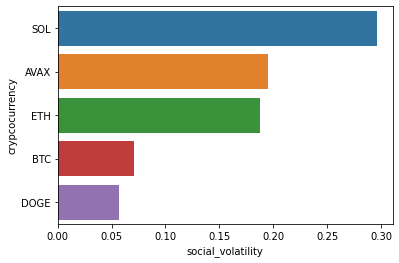

In [39]:
sns.barplot(
    x="social_volatility", y="crypcocurrency", data=social_volatilities_df
)